In [1]:
!pip install vizdoom

In [2]:
!pip install opencv-python==4.5.5.62

In [3]:
!pip install gym==0.19.0

In [4]:
!pip install matplotlib==3.5.1 

In [1]:
from vizdoom import *
import random
import time 
import numpy as np

In [2]:
game = DoomGame()
game.load_config('game/VizDoom/scenarios/deadly_corridor_s1.cfg')
game.init()

In [3]:
actions = np.identity(7, dtype=np.uint8)
state = game.get_state()
state.game_variables

array([100.,   0.,   0.,  -1.])

In [4]:
episodes = 10 
for episode in range(episodes): 
    game.new_episode()
    while not game.is_episode_finished():  
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4)
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [ ]:
game.close()

# Developing the Gym Environment

In [5]:
from gym import Env
from gym.spaces import Discrete, Box 
import cv2

In [6]:
class VizDoomGym(Env): 
    def __init__(self, render=False, config='game/VizDoom/scenarios/deadly_corridor_s2.cfg'): 
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config)
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(7)
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52 

    def step(self, action):
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) 
        
        reward = 0  
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200  + ammo_delta*5 
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        return state, reward, done, info 

    def render(): 
        pass

    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    def close(self): 
        self.game.close()

In [10]:
env = VizDoomGym(render=True)

In [8]:
state = env.reset()

In [9]:
env.close()

# Converting to greyscale

In [11]:
from matplotlib import pyplot as plt

In [12]:
from stable_baselines3.common import env_checker

C:\Users\zaoun\anaconda3\envs\mariorl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
env_checker.check_env(env)

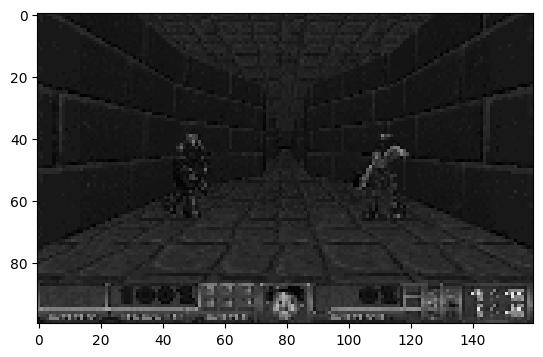

In [14]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# Making a callback to save the model

In [48]:
import os 
from stable_baselines3.common.callbacks import BaseCallback

In [49]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [50]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [51]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Training 

In [15]:
from stable_baselines3 import PPO

In [16]:
env = VizDoomGym(config='game/VizDoom/scenarios/deadly_corridor_s2.cfg')

In [54]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [55]:
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_corridor\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.2     |
|    ep_rew_mean     | 21.2     |
| time/              |          |
|    fps             | 12       |
|    iterations      | 1        |
|    time_elapsed    | 328      |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 87.5       |
|    ep_rew_mean          | 43         |
| time/                   |            |
|    fps                  | 5          |
|    iterations           | 2          |
|    time_elapsed         | 1472       |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01213121 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.92      |
|    explained_variance   | 8.4e-06    |
|    lea

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 44        |
|    ep_rew_mean          | 122       |
| time/                   |           |
|    fps                  | 3         |
|    iterations           | 11        |
|    time_elapsed         | 11268     |
|    total_timesteps      | 45056     |
| train/                  |           |
|    approx_kl            | 0.0568993 |
|    clip_fraction        | 0.375     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.78     |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.0001    |
|    loss                 | 2.45e+03  |
|    n_updates            | 100       |
|    policy_gradient_loss | 0.0113    |
|    value_loss           | 8.9e+03   |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 44.3        |
|    ep_rew_mean          | 138   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 46.5        |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 3           |
|    iterations           | 21          |
|    time_elapsed         | 25854       |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.046481118 |
|    clip_fraction        | 0.447       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0001      |
|    loss                 | 4.85e+03    |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.0365      |
|    value_loss           | 8e+03       |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 49.2      

KeyboardInterrupt: 

# Testing of our trained model

In [17]:
from stable_baselines3.common.evaluation import evaluate_policy

In [18]:
model = PPO.load('./train/train_corridor/best_model_100000')

In [19]:
env = VizDoomGym(render=True, config='game/VizDoom/scenarios/deadly_corridor_s2.cfg')

In [20]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\zaoun\anaconda3\envs\mariorl\lib\site-packages\stable_baselines3\common\evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.